# Using a radial basis function network to predict $K_{\mathrm{c}}$ and $\nu$ for the 4-state clock model

In the paper, we showed the result of fitting a radial basis function network to

$$E(K,N_{\mathrm{s}})=\big\langle \mathcal{H}(K,N_{\mathrm{s}})/N_{\mathrm{s}}^2 \big\rangle$$

for the 4-state clock model at fixed $N_{\mathrm{s}}=48,64,96,128,196,256$. In this notebook, we're going to use that fit to predict the pseudocritical temperature $K_{\mathrm{c}}(N_{\mathrm{s}})$ from the heat capacity
$$C_{V}(K,N_{\mathrm{s}})=-K^2\frac{\mathrm{d}E(K,N_{\mathrm{s}})}{\mathrm{d} K}.$$
From $K_{\mathrm{c}}(N_{\mathrm{s}})$, we will extract $K_{\mathrm{c}}$ and $\nu$ by extrapolating $K_{\mathrm{c}}(N_{\mathrm{s}})$ to $1/N_{\mathrm{s}} \rightarrow 0$ using

$$K_{\mathrm{c}}(N_{\mathrm{s}})=K_{\mathrm{c}}+\kappa N_{\mathrm{s}}^{-1/\nu}.$$

In this notebook, we're going to focus on extracting information from a radial basis function network that has already been fit to data. The data from which each interpolation was done is located in `examples/example_data/clock4`. First, let's load up some modules.

In [1]:
""" External modules """
import gvar as gv # Peter Lepage's GVar module
import numpy as np # NumPy for number crunching

""" Local modules """
import example_tools # For getting example data

""" SwissFit modules """
from swissfit import fit # SwissFit fitter module
from swissfit.machine_learning import radial_basis # Module for radial basis function network
from swissfit.optimizers import scipy_least_squares # Trust region reflective local optimizer
from swissfit.empirical_bayes import single_parameter_surrogate # Empirical Bayes optimizer

Now let's set up the radial basis function network.

In [2]:
# Define network topology
network_topology = {
    'lyr1': { # Hidden layer
        'in': 1, 'out': 4, # Dimension of input & output
        'activation': 'exp', # Exponential activation
    },
    'lyr2': { # Output layer
        'in': 4, 'out': 1,
        'activation': 'linear' # Linear activation
    }
}

# Create neural network
neural_network = radial_basis.RadialBasisNeuralNetwork(network_topology)

Then grab the data

In [3]:
# Grab data
data = example_tools.clock4_interp(['48', '64', '96', '128', '196', '256'])

Now let's calculate the the heat capacity and extract from it $K_{\mathrm{c}}(N_{\mathrm{s}})$. While we're at it, we'll go ahead and plot the heat capacity as well.

Text(0, 0.5, '$C_{V}(K,N_{\\mathrm{s}})$')

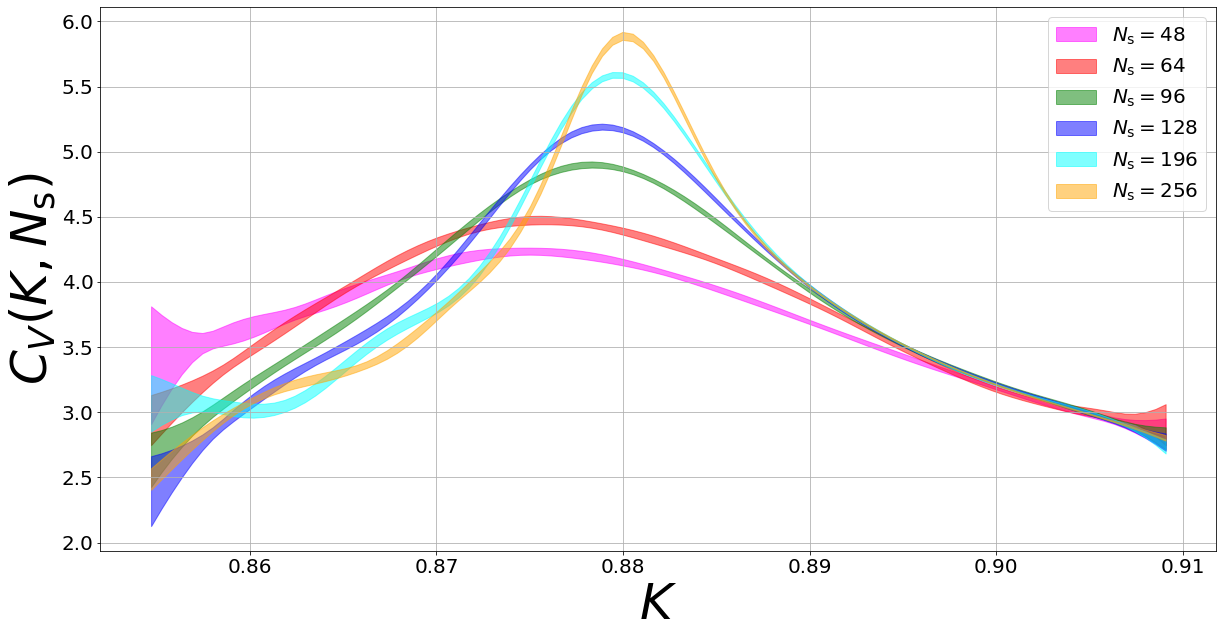

In [4]:
""" Get plotting set up """
# Import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.close()

# Set figure information up
colors = {
    '48': 'magenta', '64': 'red', '96': 'green', 
    '128': 'blue', '196': 'cyan', '256': 'orange'
}

# Values of K over which the heat capacity will be plotted
Kl, Kh = 1. / 1.17, 1. / 1.1
Ks = np.linspace(Kl, Kh, 100)

""" Set up analysis for extracting K_c(N_s) """
# Ranges of K over which the root finding algorithm will search
KlKh_root_range = {
    '48': [1./1.11, 1./1.15],
    '64': [1./1.11, 1./1.15],
    '96': [1./1.11, 1./1.15],
    '128': [1./1.11, 1./1.15],
    '196': [1./1.11, 1./1.14],
    '256': [1./1.11, 1./1.14]
}

# Dictionary to save roots
roots = {}

""" Plot data and get K_c(N_s) """
# Plot each volume
for vol in data.keys():
    """ Set interpolation up """
    # Define fit function interpolation of energy
    energy = lambda K: np.ravel(neural_network.out(K, data[vol]))

    # Define specific heat function
    def heat_capacity(k):
        if not isinstance(k, gv.GVar): K, Kpe = [[gv.gvar(k, 0.)]], [[gv.gvar(k, 0.) + heat_capacity.eps]]
        else: K, Kpe = [[k]], [[k + heat_capacity.eps]]
        return -K[0][0]**2. * (energy(Kpe)[0] - energy(K)[0]) / heat_capacity.eps
    heat_capacity.eps = 1e-7 # Epsilon for finite difference

    # Define derivative of heat capacity to find peak from root of derivative
    def dheat_capacity(k):
        return (heat_capacity(k + dheat_capacity.eps) - heat_capacity(k)) / dheat_capacity.eps
    dheat_capacity.eps = 1e-7 # Epsilon for finite difference

    """ Plot heat capacity """
    Cvs = [heat_capacity(K) for K in Ks] # Heat capacity
    plt.fill_between(
        Ks,
        gv.mean(Cvs) - gv.sdev(Cvs),
        gv.mean(Cvs) + gv.sdev(Cvs),
        alpha = 0.5, color = colors[vol],
        label = '$N_{\mathrm{s}}=' + vol + '$'
    ) # Fill-between plot
    
    """ Get K_c(N_s) from root of derivative of heat capacity around peak """
    # Get K_c(N_s) from root 
    roots[float(vol)] = gv.root.refine(dheat_capacity, KlKh_root_range[vol])

""" Finish figure up """
plt.grid('on')
plt.legend(fontsize = 20.)
plt.gca().xaxis.set_tick_params(labelsize = 20.)
plt.gca().yaxis.set_tick_params(labelsize = 20.)
plt.xlabel('$K$', fontsize = 50.)
plt.ylabel('$C_{V}(K,N_{\mathrm{s}})$', fontsize = 50.)

We have now calculated the values of $K_{\mathrm{c}}(K_{\mathrm{s}})$ from the peaks of the specific heat in the figure above; e.g., 
$$K_{\mathrm{c}}(N_{\mathrm{s}}) \equiv \mathrm{min}_{K} \mathrm{abs} \bigg( \frac{\mathrm{d}C_{V}(K,N_{\mathrm{s}})}{\mathrm{d}K}\bigg), $$
where $\mathrm{abs}(\cdot)$ is the absolute value because Markdown is being weird about rendering bars. Let's use SwissFit to extrapolate $K_{\mathrm{c}}(K_{\mathrm{s}})$ to $1/N_{\mathrm{s}} \rightarrow 0$ using 
$$K_{\mathrm{c}}(N_{\mathrm{s}})=K_{\mathrm{c}}+\kappa N_{\mathrm{s}}^{-1/\nu}.$$
We will use the basin hopping algorithm to be careful and we will also use the surrogate-based empirical Bayes procedure discussed in the paper to estimate the prior on $\kappa$.

In [5]:
""" Set up data and fit function """
# Get data
fit_data = {}
fit_data['x'], fit_data['y'] = np.transpose([[1. / Ns, K] for Ns, K in roots.items()])
fit_data['x'] = fit_data['x'].reshape( (len(fit_data['x']),1) )

# Define fit function
def fit_fcn(x, p):
    return p['tc'][0] + p['kappa'][0] * x**p['nu_inverse'][0]

""" Define function to do the fit at different values of kappa """
# This function does the fit at a particlar value for the kappa prior
def do_fit(kappa_width, return_fit = False):
    # Step 1.) Create SwissFit fitter
    fitter = fit.SwissFit(
        udata = fit_data,
        uprior = {'kappa': [gv.gvar(0., kappa_width)]},
        fit_fcn = fit_fcn,
        p0 = {'tc': [0.89], 'nu_inverse': [0.5]}
    )

    # Step 2.) Create (local) optimizer
    local_optimizer = scipy_least_squares.SciPyLeastSquares(fitter = fitter)

    # Step 3.) Do fit
    fitter(local_optimizer)

    # Return negative value of log of marginal likelihood
    if return_fit: return fitter
    else: return -fitter.logml

""" Set up empirical Bayes analysis """
# Create empirical Bayes object
emp_bayes_fit = single_parameter_surrogate.SingleParameterSurrogate(
    fcn = do_fit, # Our "do_fit" function that does the fit & calculates the marginal likelihood
    lb = 0.1, ub = 4.0, # Lower & upper bound on kappa_width
    n_points = 40, # Number of fits to perform
    spline_algorithm = 'steffen', # Use a monotonic spline
)

# Do empirical Bayes analysis
kappa_width_star = emp_bayes_fit().x[0]

# Fit data at lambda^{*} from empirical Bayes
fit_result = do_fit(kappa_width_star, return_fit = True)

# Print result of the fit
print(fit_result)

# Save fit parameters
fit_parameters = fit_result.p


SwissFit: 🧀
   chi2/dof [dof] = 0.64 [4]   Q = 0.64   (Bayes) 
   chi2/dof [dof] = 0.76 [3]   Q = 0.51   (freq.) 
   AIC [k] = 8.29 [3]   logML = 30.001*

Parameters*:
     tc
             1                0.88137(74)   [n/a]
     nu_inverse
             1                   0.96(33)   [n/a]
     kappa
             1                  -0.25(32)   [0.00(50)]

Estimator:
   SwissFit optimizer object
*Laplace approximation



Alright, so our extrapolation tells us that our data indicates $K_{\mathrm{c}}=0.88137(74)$ and $\nu=1.04(36)$. The exact values are $K_{\mathrm{c}}=\log\big(1+\sqrt{2}\big) \approx 0.88137$ and $\nu=1$, so we are right on the money. We expect $\nu=1$ from the 4-state clock model being in the same universality class as the 2-state Potts (Ising) model. It is (somewhat) of a spooky coincidence that it also has the same critical temperature, though my personal guess is that this is because the 4-state clock model is identical to two copies of the Ising model around $K_{\mathrm{c}}$.